## SetUp

In [1]:
# preprocessing

# The only thing we do is band-pass filter between 1 and 50 Hz,
# and if the signal exceeds 150 μV on any channel, we consider it an artifact.

import mne
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
os.chdir('..')


# helpers
def flag_bad_channels(raw, l_freq=1., h_freq=50.,
                      var_z_thr=-3.0,         # flatness threshold (z-score)
                      psd_lo_thr=-3.0,        # very low broadband PSD (z-score)
                      beta_hi_thr=3.0,        # high beta/gamma outlier (z-score)
                      beta_band=(15, 40),
                      broad_band=(1, 45),
                      picks="eeg"):
    """Return list of bad channel names based on amplitude + PSD outliers."""
    raw_f = raw.copy().filter(l_freq, h_freq, picks=picks, verbose=False)

    # --- 1) Flat / dead channels via variance ---
    data = raw_f.get_data(picks=picks)
    ch_vars = np.var(data, axis=1)
    var_z = (np.log(ch_vars) - np.mean(np.log(ch_vars))) / np.std(np.log(ch_vars))
    bad_var = np.array(raw_f.ch_names)[var_z < var_z_thr]

    # --- 2) PSD-based broadband low-power channels ---
    psd, freqs = mne.time_frequency.psd_array_welch(
        data, sfreq=512, fmin=broad_band[0], fmax=broad_band[1],
        n_fft=2048, verbose=False
    )
    broad_pow = psd.mean(axis=1)
    broad_z = (np.log(broad_pow) - np.mean(np.log(broad_pow))) / np.std(np.log(broad_pow))
    bad_broad = np.array(raw_f.ch_names)[broad_z < psd_lo_thr]

    # --- 3) High beta/gamma outliers (EMG / bad contact) ---
    psd_beta, freqs_beta = mne.time_frequency.psd_array_welch(
        data, sfreq=512, fmin=beta_band[0], fmax=beta_band[1],
        n_fft=2048, verbose=False
    )
    beta_pow = psd_beta.mean(axis=1)
    beta_z = (np.log(beta_pow) - np.mean(np.log(beta_pow))) / np.std(np.log(beta_pow))
    bad_beta = np.array(raw_f.ch_names)[beta_z > beta_hi_thr]

    bads = sorted(set(bad_var) | set(bad_broad) | set(bad_beta))

    report = {
        "bad_var": list(bad_var),
        "bad_broad_low": list(bad_broad),
        "bad_beta_high": list(bad_beta),
        "var_z": dict(zip(raw_f.ch_names, var_z)),
        "broad_z": dict(zip(raw_f.ch_names, broad_z)),
        "beta_z": dict(zip(raw_f.ch_names, beta_z)),
    }
    return bads, report

def flag_bad_neighbors(raw, picks="eeg", corr_z_thr=-2.5):
    """Flag channels whose average correlation with neighbors is abnormally low."""
    # find sensor adjacency (from montage)
    adjacency, ch_names = mne.channels.find_ch_adjacency(raw.info, ch_type='eeg')
    adjacency = adjacency.toarray()

    data = raw.get_data(picks=picks)
    corr = np.corrcoef(data)

    avg_neighbor_corr = []
    for i, ch in enumerate(ch_names):
        neighbors = np.where(adjacency[i] == 1)[0]
        if len(neighbors) == 0:
            avg_neighbor_corr.append(np.nan)
            continue
        avg_neighbor_corr.append(np.mean(corr[i, neighbors]))

    avg_neighbor_corr = np.array(avg_neighbor_corr, dtype=float)
    z = (avg_neighbor_corr - np.nanmean(avg_neighbor_corr)) / np.nanstd(avg_neighbor_corr)

    bad_corr = np.array(ch_names)[z < corr_z_thr]
    return bad_corr, dict(zip(ch_names, z))


def flag_hf_noisy(raw, hf_band=(30, 50), lf_band=(1, 30),
                  hf_ratio_z_thr=3.0, picks="eeg"):
    raw_f = raw.copy().filter(1., 50., picks=picks, verbose=False)
    data = raw.get_data(picks=picks)

    psd, freqs = mne.time_frequency.psd_array_welch(
        data, 512, fmin=1, fmax=50, n_fft=2048, verbose=False
    )

    hf = psd[:, (freqs >= hf_band[0]) & (freqs <= hf_band[1])].mean(axis=1)
    lf = psd[:, (freqs >= lf_band[0]) & (freqs <= lf_band[1])].mean(axis=1)

    ratio = np.log(hf / lf)
    z = (ratio - ratio.mean()) / ratio.std()

    bad_hf = np.array(raw_f.ch_names)[z > hf_ratio_z_thr]
    return bad_hf, dict(zip(raw_f.ch_names, z))


def flag_drift_jumps(raw, picks="eeg",
                     drift_z_thr=3.0,
                     jump_z_thr=3.0,
                     hp=0.5):
    """
    Detect electrodes with non-physiological drifts and fast baseline jumps.
    """
    sfreq = raw.info['sfreq']

    # High-pass lightly to isolate drifts (slow stuff <0.5 Hz)
    raw_lp = raw.copy().filter(None, hp, picks=picks, verbose=False)
    raw_hp = raw.copy().filter(hp, None, picks=picks, verbose=False)

    data_lp = raw_lp.get_data(picks=picks)   # slow drifts
    data_hp = raw_hp.get_data(picks=picks)   # jumps/edges

    # Drift metric = std of <0.5 Hz component
    drift_std = data_lp.std(axis=1)
    drift_z = (drift_std - drift_std.mean()) / drift_std.std()

    # Jump metric = median absolute derivative of >0.5 Hz component
    deriv = np.abs(np.diff(data_hp, axis=1))
    jump_med = np.median(deriv, axis=1)
    jump_z = (jump_med - jump_med.mean()) / jump_med.std()

    chs = raw_lp.ch_names
    bad_drift = np.array(chs)[drift_z > drift_z_thr]
    bad_jump  = np.array(chs)[jump_z > jump_z_thr]

    bads = sorted(set(bad_drift) | set(bad_jump))

    return bads, {
        "drift_z": dict(zip(chs, drift_z)),
        "jump_z": dict(zip(chs, jump_z)),
        "bad_drift": list(bad_drift),
        "bad_jump": list(bad_jump),
    }

def correct_bad_names(bads):
    return [str(i) for i in bads]

## Detect bad channels

In [3]:
# bad_channels = pd.DataFrame(index=range(1, 33), columns=['art_nl', 'art_l', 'city_nl', 'city_l'])
bad_channels = pd.read_csv('data/bad_channels.csv', index_col=0)

### open data

In [6]:
sub_id = '03'
movie = 'city'
order = 'l'
movie_order = movie + '_' + order
file_name = f'{sub_id}_{movie_order}'
eeg_path = f'data/eeg/{movie}_edf/{movie_order}/{file_name}.edf'
raw = mne.io.read_raw_edf(eeg_path, preload=True)
raw.drop_channels(['Status'])

mon = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(mon)

bad_var, rep = flag_bad_channels(raw)
bad_corr, corr_z = flag_bad_neighbors(raw)
bad_hf, hf_z = flag_hf_noisy(raw)
bad_drift, rep4 = flag_drift_jumps(raw)

bad_var = correct_bad_names(bad_var)
bad_corr = correct_bad_names(bad_corr)
bad_hf = correct_bad_names(bad_hf)
bad_drift = correct_bad_names(bad_drift)

# FRONTAL_EXEMPT = ["Fp1","Fp2","AF7","AF8","AF3","AF4"]
# bad_drift = [ch for ch in bad_drift if ch not in FRONTAL_EXEMPT]

bads = sorted(set(bad_var) |
              set(bad_corr) |
              set(bad_hf) |
              set(bad_drift))

print("Auto-flagged bads:", bads)
print("Why:")
print("  flat/low-var:", rep["bad_var"])
print("  broadband-too-low:", rep["bad_broad_low"])
print("  beta/gamma-too-high:", rep["bad_beta_high"])
print("  Neighbor-correlation bads:", bad_corr)
print("  HF-noisy bads:", bad_hf)
print("  slow drifts & jumps:", bad_drift)

# raw.info["bads"] = bads
# raw.interpolate_bads(reset_bads=False)

Extracting EDF parameters from /Users/yeganeh/Codes/movie_project/data/eeg/city_edf/city_l/03_city_l.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 263679  =      0.000 ...   514.998 secs...
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 32
Auto-flagged bads: ['T8']
Why:
  flat/low-var: []
  broadband-too-low: []
  beta/gamma-too-high: []
  Neighbor-correlation bads: []
  HF-noisy bads: []
  slow drifts & jumps: ['T8']


In [86]:
# raw.notch_filter([50, 100])
# sus_ch = 'T8'
for sus_ch in bads:

    data = raw.get_data(picks="eeg")
    var = np.var(data, axis=1)
    z_var = (var - var.mean()) / var.std()

    vars = dict(zip(raw.ch_names, z_var))
    corr = np.corrcoef(data)
    idx = raw.ch_names.index(sus_ch)
    mean_corr = np.mean(np.delete(corr[idx], idx))

    psds, freqs = mne.time_frequency.psd_array_welch(
        raw.get_data(), sfreq=512, fmin=20, fmax=40, verbose=False
    )
    hf_power = psds.mean(axis=1)
    z_hf = (hf_power - hf_power.mean()) / hf_power.std()

    print(sus_ch, vars[sus_ch], mean_corr, dict(zip(raw.ch_names, z_hf))[sus_ch])

CP6 3.223365246274323 0.12335612772811427 0.3181792508594596
F8 0.013205970313715985 0.25370441512478575 1.9794334158581661
O1 3.525289659706718 0.10775458316249092 1.4793761843075177


### Visually inspect bad channels

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


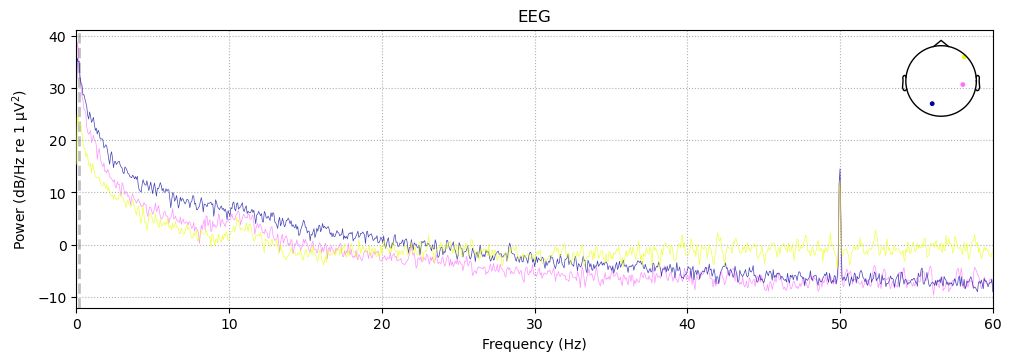

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


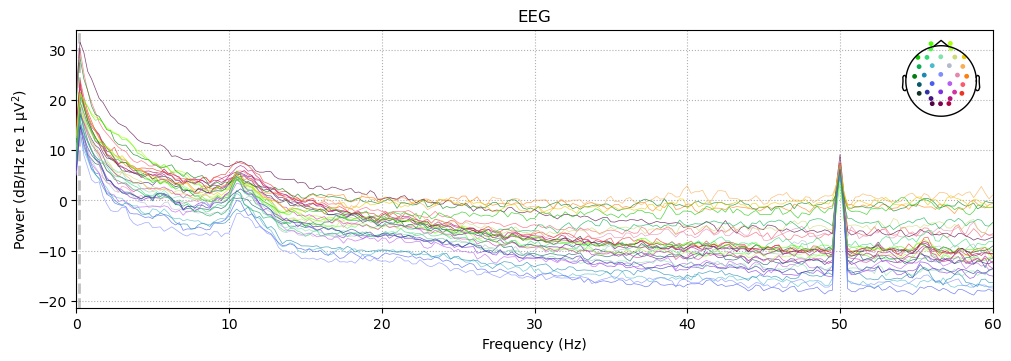

In [ ]:
# Frequency domian
raw.copy().pick_channels(set(bads)).plot_psd(fmax=60, spatial_colors=True, show=False, n_fft=8192)
plt.show()

raw.copy().plot_psd(fmax=60, spatial_colors=True, show=False)
plt.show()

In [ ]:
# time domian
raw.copy().notch_filter([50, 100]).plot(n_channels=33, remove_dc=True, lowpass=50, highpass=1) # 

In [ ]:
# add detected bad channels to the list
bad_channels.loc[int(sub_id), movie_order] = bads

In [128]:
import re
re.findall(r"'([^']+)'", bad_channels.loc[14, 'art_nl'])

['P7', 'T8']

Channels marked as bad:
none
